# **imports**

In [2]:
import torch
import torch.nn as nn
import numpy as np
import os
import zipfile
import matplotlib.pyplot as plt
import cv2
import torch.nn.functional as F
import torchvision.transforms.v2 as T
from torch.utils.data import DataLoader, ConcatDataset
from skimage.morphology import remove_small_objects, remove_small_holes
from skimage.feature import peak_local_max
from scipy.ndimage import label
from skimage.segmentation import watershed
from google.colab import files
import shutil
from datetime import datetime
from skimage.feature import peak_local_max
import random
import albumentations as A
from albumentations.pytorch import ToTensorV2

# **basic configurations and download data**

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_WORKERS = os.cpu_count()

BATCH_SIZE = 2
HEIGHT, WIDTH = 256, 256

In [4]:
os.makedirs('/datasets/Pannuke/download', exist_ok=True)

!wget 'https://warwick.ac.uk/fac/cross_fac/tia/data/pannuke/fold_1.zip' -O /datasets/Pannuke/download/pannuke_fold1.zip
!wget 'https://warwick.ac.uk/fac/cross_fac/tia/data/pannuke/fold_2.zip' -O /datasets/Pannuke/download/pannuke_fold2.zip
!wget 'https://warwick.ac.uk/fac/cross_fac/tia/data/pannuke/fold_3.zip' -O /datasets/Pannuke/download/pannuke_fold3.zip

--2025-11-29 16:39:49--  https://warwick.ac.uk/fac/cross_fac/tia/data/pannuke/fold_1.zip
Resolving warwick.ac.uk (warwick.ac.uk)... 137.205.28.41
Connecting to warwick.ac.uk (warwick.ac.uk)|137.205.28.41|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 700275281 (668M) [application/zip]
Saving to: ‘/datasets/Pannuke/download/pannuke_fold1.zip’

/datasets/Pannuke/d 100%[===================>] 667.83M  12.4MB/s    in 76s     

2025-11-29 16:41:06 (8.73 MB/s) - ‘/datasets/Pannuke/download/pannuke_fold1.zip’ saved [700275281/700275281]

--2025-11-29 16:41:06--  https://warwick.ac.uk/fac/cross_fac/tia/data/pannuke/fold_2.zip
Resolving warwick.ac.uk (warwick.ac.uk)... 137.205.28.41
Connecting to warwick.ac.uk (warwick.ac.uk)|137.205.28.41|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 658842552 (628M) [application/zip]
Saving to: ‘/datasets/Pannuke/download/pannuke_fold2.zip’

/datasets/Pannuke/d 100%[===================>] 628.32M  11.2MB/s    i

In [5]:
data_path = os.path.join('/datasets/Pannuke/data')
os.makedirs(data_path, exist_ok=True)

In [6]:
with zipfile.ZipFile('/datasets/Pannuke/download/pannuke_fold1.zip', 'r') as file:
  file.extractall(data_path)

with zipfile.ZipFile('/datasets/Pannuke/download/pannuke_fold2.zip', 'r') as file:
  file.extractall(data_path)

with zipfile.ZipFile('/datasets/Pannuke/download/pannuke_fold3.zip', 'r') as file:
  file.extractall(data_path)

In [7]:
fold1_images_filepath = os.path.join(data_path, 'Fold 1',  'images', 'fold1', 'images.npy')
fold2_images_filepath = os.path.join(data_path, 'Fold 2',  'images', 'fold2', 'images.npy')
fold3_images_filepath = os.path.join(data_path, 'Fold 3',  'images', 'fold3', 'images.npy')

fold1_masks_filepath = os.path.join(data_path, 'Fold 1',  'masks', 'fold1', 'masks.npy')
fold2_masks_filepath = os.path.join(data_path, 'Fold 2',  'masks', 'fold2', 'masks.npy')
fold3_masks_filepath = os.path.join(data_path, 'Fold 3',  'masks', 'fold3', 'masks.npy')

In [8]:
images = np.load(fold1_images_filepath, mmap_mode='r')
masks = np.load(fold1_masks_filepath, mmap_mode='r')

# **groundtruth generator**



In [9]:
def groundtruth_generator(input_mask):
  CHANNELS, HEIGHT, WIDTH = input_mask.shape

  instance_map = np.zeros((HEIGHT, WIDTH), dtype=np.float32)

  np_map = np.zeros((2, HEIGHT, WIDTH), dtype=np.float32)
  hv_map = np.zeros((2, HEIGHT, WIDTH), dtype=np.float32)
  tp_map = np.zeros((CHANNELS, HEIGHT, WIDTH), dtype=np.float32)

  '''
    np map is a 2 channeld array. it dont hase batch size. because it would be generated with a pytorch Dataset module and it is 3 dimentional
    hv mape hase 2 channels. one for horisontal discplacements and another one for vertical dicplacements
    tp map hase 6 channels that each channel is included 0 pixels of background and pixels that are not in that class type.
    and 1 to n unique ids for each instance of nucleuses
    for that class
  '''


  next_id = 1 # unique ids for global instance map over all classes
  for channel_id in range(CHANNELS - 1): # if we have n channels, we would have 0 to n-1 instances
    mask_channel = input_mask[channel_id]

    instance_ids = np.unique(mask_channel) #finding background and nucleuses ids
    instance_ids = instance_ids[instance_ids != 0] #we dont mind backgound pixels

    for instance_id in instance_ids:
      y_coords, x_coords = np.where(mask_channel == instance_id) #finding coordinates for all pixels that are in each nucleus

      y_centroid, x_centroid = np.mean(y_coords), np.mean(x_coords) # we find centeral line in horizontal and vertrical direction by caluclating mean over x and y coordinates

      hv_map[0, y_coords, x_coords] = x_centroid - x_coords # finding distance of each pixel from its nuiclues center of mass seperately for x and y vectors
      hv_map[1, y_coords, x_coords] = y_centroid - y_coords

      hv_map[0, y_coords, x_coords] = hv_map[0, y_coords, x_coords] / (np.max(np.abs(x_centroid - x_coords)) + 1e-5) #ranging all displacements between -1 to 1 in every nucleus and adding a smoothenes for getting away from zero division
      hv_map[1, y_coords, x_coords] = hv_map[1, y_coords, x_coords] / (np.max(np.abs(y_centroid - y_coords)) + 1e-5)

      instance_map[y_coords, x_coords] = next_id
      tp_map[channel_id, y_coords, x_coords] = 1

      next_id += 1

  np_map[0] = (instance_map > 0).astype(np.float32) # converting all bigger than 1 ids to 1. np map is just a boolean map with 0 and 1 values
  np_map[1] = 1 - np_map[0]

  hv_map *= np_map[0] # displacements are just considered for nnuclues pixels. not all pixels(background and nucleus)

  tp_map[-1] = np_map[1] # the channel of background pixels are equal with this channel in np map. in both them, pixels that are not in any of nuclueses in all of classes

  return instance_map, np_map, hv_map, tp_map

# **loss calculator**

In [10]:
class LossCalculator:
  def dice_loss(self, output, gt):
    '''
    output is a 3 dimentional array that its values are model raw logits.
    gt is generated groundtruth for each map specially.
    '''

    channels = output.shape[1] # getting channels num
    output = F.softmax(output, dim=1) # convert raw logits to probabilities
    output = output.argmax(dim=1) #convert 2 channeled map to argmaxed 1 channeled map
    output = F.one_hot(output, num_classes=channels) #convert it to one hot encoded map that its channels are equal to its gt now and its values are 0 and 1 for nuclueses and background.
    output = output.permute(0, 3, 1, 2) #(batch_size, height, width, channels) ==> (batch_size, channels, height, width)

    overlap = 2 * torch.sum(output * gt) # specify where both of prediction and gt pixels are 1
    nuclues_pixels_num = torch.sum(output) + torch.sum(gt)

    dice_coeficient = overlap / nuclues_pixels_num
    dice_loss = 1 - dice_coeficient

    #obove calculations are according to dice loss calculatoins

    return dice_loss

  def gradient_calculator(self, hv_map):

    '''
    this methode calculates the rate of change of input hv map.
    we have two kernels that each one can calculate horizontal and vertrical gradient for heach ho-ver map. so we would have 4 gradient maps at the end.
    '''

    device = hv_map.device
    sobel_x = torch.tensor([[1, 0, -1],
                            [2, 0, -2],
                            [1, 0, -1]], dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(0)

    sobel_y = torch.tensor([[1, 2, 1],
                            [0, 0, 0],
                            [-1, -2, -1]], dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(0)


    x_map_x_grad = F.conv2d(hv_map[:, 0:1], sobel_x, padding=1)
    x_map_y_grad = F.conv2d(hv_map[:, 0:1], sobel_y, padding=1)

    y_map_x_grad = F.conv2d(hv_map[:, 1:2], sobel_x, padding=1)
    y_map_y_grad = F.conv2d(hv_map[:, 1:2], sobel_y, padding=1)

    eps = 1e-8

    x_map_gradient = torch.sqrt(x_map_x_grad**2 + x_map_y_grad**2 + eps) #converting horizontal vertical gradient map to one gradient map for each ho-ver map
    y_map_gradient = torch.sqrt(y_map_x_grad**2 + y_map_y_grad**2 + eps)

    return x_map_gradient, y_map_gradient


  def np_loss(self, np_output, np_gt, lambda_c=1, lambda_e=1):

    cross_entropy = nn.CrossEntropyLoss(reduction='mean') # cross entropy loss. reduction=mean takes an average on all of values and return a single value
    loss_c = cross_entropy(np_output, np_gt.argmax(dim=1).long()) # np_gt is 2 channeled. so we should convert it to 1D, 0 and 1 array.

    loss_e = self.dice_loss(np_output, np_gt)

    total_loss = lambda_c * loss_c + lambda_e * loss_e # lambda_c and lambda_b are some constants that are usually 1 and for hv_map gradient loss is 2

    return total_loss


  def hv_loss(self, hv_output, hv_gt, lambda_a=1, lambda_b=2):
    loss_a = torch.mean((hv_output - hv_gt)**2) # mean squared error :)

    output_x_grad_map, output_y_grad_map = self.gradient_calculator(hv_output) #gradient MSE for predictions
    gt_x_grad_map, gt_y_grad_map = self.gradient_calculator(hv_gt) # gradient MSE for gt maps

    loss_b = torch.mean((output_x_grad_map - gt_x_grad_map)**2) + torch.mean((output_y_grad_map - gt_y_grad_map)**2) # this calculation is according official hovernet paper

    total_loss = lambda_a * loss_a + lambda_b * loss_b

    return total_loss

  def tp_loss(self, tp_output, tp_gt, lambda_d=1, lambda_f=1):

    cross_entropy = nn.CrossEntropyLoss(reduction='mean')

    loss_d = cross_entropy(tp_output, tp_gt.argmax(dim=1).long())

    loss_f = self.dice_loss(tp_output, tp_gt)

    total_loss = lambda_d * loss_d + lambda_f * loss_f

    return total_loss

# **data visualization**

normal images


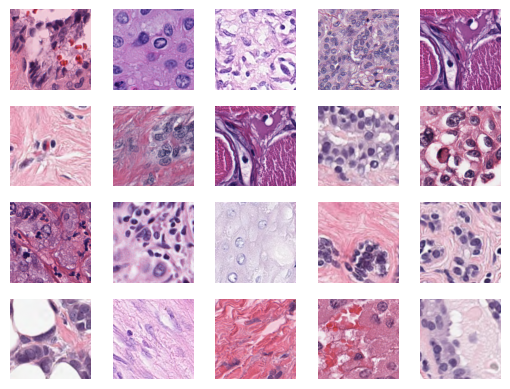

instance map(every nucleus has uique pixel id without respect to its type)


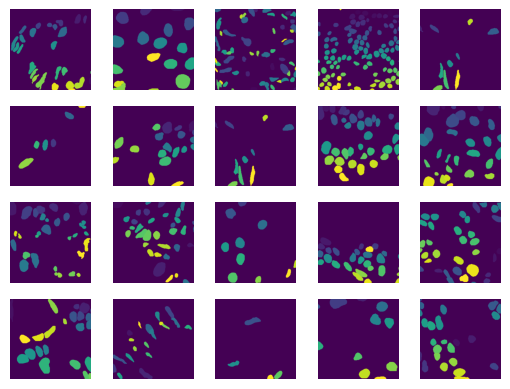

horizontal map


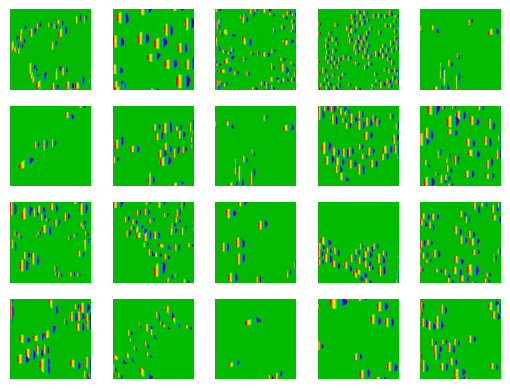

vertical map


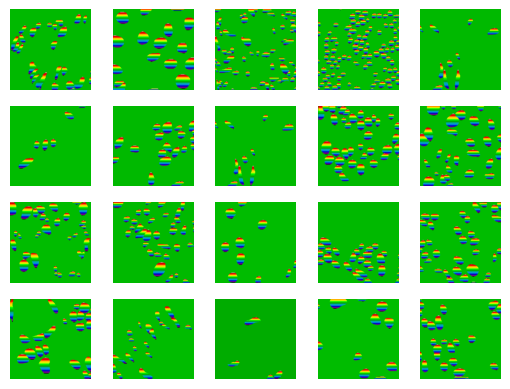

In [11]:
def data_plotter(fold_images_path, fold_masks_path):
  images_file = np.load(fold_images_path, mmap_mode='r')
  masks_file = np.load(fold_masks_path, mmap_mode='r')
  random_indexes = np.random.randint(0, images_file.shape[0], size=20)
  random_images = images_file[random_indexes]
  random_masks = masks_file[random_indexes]

  print('normal images')
  for idx, image in enumerate(random_images):
    plt.subplot(4, 5, idx+1)
    plt.imshow(image / 255.0)
    plt.axis('off')
  plt.show()

  print('instance map(every nucleus has uique pixel id without respect to its type)')
  for idx, mask in enumerate(random_masks):
    instance_mask= groundtruth_generator(mask)[0]
    plt.subplot(4, 5, idx+1)
    instance_map = groundtruth_generator(torch.from_numpy(mask).permute(2, 0, 1))[0]
    plt.imshow(instance_map)
    plt.axis('off')
  plt.show()


  print('horizontal map')
  for idx, mask in enumerate(random_masks):
    plt.subplot(4, 5, idx+1)
    hv_map = groundtruth_generator(torch.from_numpy(mask).permute(2, 0, 1))[2]
    plt.imshow(hv_map[0], cmap='nipy_spectral')
    plt.axis('off')
  plt.show()

  print('vertical map')
  for idx, mask in enumerate(random_masks):
    plt.subplot(4, 5, idx+1)
    hv_map = groundtruth_generator(torch.from_numpy(mask).permute(2, 0, 1))[2]
    plt.imshow(hv_map[1], cmap='nipy_spectral')
    plt.axis('off')
  plt.show()

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.image")

data_plotter(fold1_images_filepath, fold1_masks_filepath)



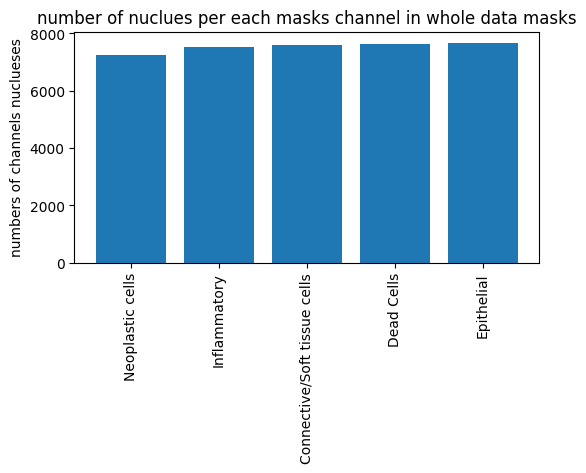

In [12]:
def nucluesnums_per_type_plotter(masks_path):
  global_instance_nums = [0, 0, 0, 0, 0]
  for mask_path in masks_path:
    mask_file = np.load(mask_path, mmap_mode='r')
    for mask in mask_file:
      for channel_id in range(len(global_instance_nums)):
        instance_ids = np.unique(mask[channel_id])
        instance_ids = instance_ids[instance_ids != 0]
        global_instance_nums[channel_id] += len(instance_ids)

  types_names = ['Neoplastic cells',
                 'Inflammatory',
                 'Connective/Soft tissue cells',
                 'Dead Cells',
                 'Epithelial']

  plt.figure(figsize=(6, 3))
  plt.bar(types_names, global_instance_nums)
  plt.xticks(rotation=90, fontsize=10)
  plt.ylabel('numbers of channels nuclueses')
  plt.title('number of nuclues per each masks channel in whole data masks')

nucluesnums_per_type_plotter([fold1_masks_filepath])

# **backbone implementation**

In [13]:
class ResidualUnit(torch.nn.Module):
  '''
  this class is a pytorch module that its role is backbone in hovernet. image size would decrease during forwarding pass through this network.
  '''
  def __init__(self, in_channels, convs_outchannels, convs_kernelsizes, stride=1):
    '''
      this is a pre_activated residual unit.
        each residual unit has a stride. this stride is for second conv layer. other conv layers's strides are just 1.
      we have a list like this [outchannels for conv layer_1, layer_2, layer_3]. for each residual block that is created from several residula unit, this
      out channels are equal for all block's units.

        conv_kernelsizes are a list like this [size_1, size_2, size_3] that shows each conv layer's receptive field's shape.
      these amounts are same for all units in blocks too.

    '''

    super(ResidualUnit, self).__init__()
    self.stride = stride

    self.in_channels = in_channels
    self.out_channels = convs_outchannels[-1] # final out channels for this unit

    self.bottleneck = nn.Sequential(
        nn.BatchNorm2d(in_channels),
        nn.ReLU(inplace=True), #inplace=True : dont generate new array. just change input array values.
        nn.Conv2d(in_channels,
                  convs_outchannels[0],
                  kernel_size=convs_kernelsizes[0],
                  stride=1,
                  padding=0,
                  bias=False),

        nn.BatchNorm2d(convs_outchannels[0]), # the output channels of before conv layer is input channels for its after conv.
        nn.ReLU(inplace=True),
        nn.Conv2d(convs_outchannels[0],
                  convs_outchannels[1],
                  kernel_size=convs_kernelsizes[1],
                  stride=stride, # we apply stride of unit here
                  padding=1,
                  bias=False),

        nn.BatchNorm2d(convs_outchannels[1]),
        nn.ReLU(inplace=True),
        nn.Conv2d(convs_outchannels[1],
                  convs_outchannels[2],
                  kernel_size=convs_kernelsizes[2],
                  stride=1,
                  padding=0,
                  bias=False),
    )

    self.skip_projection = nn.Sequential(
        nn.Conv2d(self.in_channels,
                  self.out_channels,
                  kernel_size=1,
                  padding=0,
                  stride=stride,
                  bias=False),
        nn.BatchNorm2d(self.out_channels)
    ) # this is a simple conv that just convert the input channels and shape to bottleneck output to we could take sum over them.
    #this is where that a residual unit differs from a normal conv network.

  def forward(self, x):
    f_x = self.bottleneck(x)

    if self.stride != 1 or self.in_channels != self.out_channels :
      skip_x = self.skip_projection(x)
    else:
      skip_x = x
    output = f_x + skip_x

    return output


class ResidualBlock(torch.nn.Module):
  def __init__(self, in_channels, units_outchannels, units_kernelsizes, unit_counts, stride=1):

    #we determain the number of units for each block and put them in a module list

    super(ResidualBlock, self).__init__()

    self.stride = stride
    self.in_channels = in_channels
    self.out_channels = units_outchannels[-1] # unit final outchannels

    self.layers = nn.ModuleList()

    unit_in_channels = self.in_channels
    for unit in range(unit_counts):
      self.layers.append(
          ResidualUnit(unit_in_channels, units_outchannels, units_kernelsizes, stride=stride if unit == 0 else 1)
      ) # we just apply the stride for first residual unit in each block. so we should check that our unit instance is 0 or not.

      unit_in_channels = units_outchannels[-1] # final unit_outchannels instance is the final out channels of obove unit. so we put this amount as input channels of next unit

    self.block = nn.Sequential(*self.layers) # converting module list to nn.Sequential

  def forward(self, x):
    return self.block(x)


class HoverNetBackbone(torch.nn.Module):
  def __init__(self):
    super(HoverNetBackbone, self).__init__()

    self.stem = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=7, stride=1, padding=3, bias=False),
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True)
    )

    self.d0 = ResidualBlock(32, [32, 32, 128], [1, 3, 1], 2, stride=1)
    self.d1 = ResidualBlock(128, [64, 128, 256], [1, 3, 1], 3, stride=2)
    self.d2 = ResidualBlock(256, [128, 256, 512], [1, 3, 1], 4, stride=2)
    self.d3 = ResidualBlock(512, [256, 512, 1024], [1, 3, 1], 2, stride=2)

    self.bottleneck = nn.Conv2d(1024, 512, kernel_size=1, padding=0, stride=1, bias=False)

  def forward(self, x):

    x = self.stem(x)
    d0_output = self.d0(x)
    d1_output = self.d1(d0_output)
    d2_output = self.d2(d1_output)
    d3_output = self.d3(d2_output)
    bottleneck_output = self.bottleneck(d3_output)

    return d0_output, d1_output, d2_output, d3_output, bottleneck_output

# **deocder implementation**



In [14]:
class DenseUnit(torch.nn.Module):
  def __init__(self, in_channels, convs_outchannels, convs_kernelsizes):
    super(DenseUnit, self).__init__()

    self.dense_unit = nn.Sequential(
        nn.BatchNorm2d(in_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(
            in_channels,
            convs_outchannels[0],
            kernel_size = convs_kernelsizes[0],
            stride=1,
            padding=0,
            bias=False
        ),

        nn.BatchNorm2d(convs_outchannels[0]),
        nn.ReLU(inplace=True),
        nn.Conv2d(
            convs_outchannels[0],
            convs_outchannels[1],
            kernel_size = convs_kernelsizes[1],
            stride=1,
            padding=2,
            bias=False
        )
    )


  def forward(self, x):
    return self.dense_unit(x)


class DenseBlock(torch.nn.Module):
  def __init__(self, in_channels, units_outchannels, units_kernelsizes, unit_counts, stride=1):
    super(DenseBlock, self).__init__()

    self.stride = stride
    self.unit_counts = unit_counts

    self.before_conv = nn.Conv2d(in_channels,
                                 int(in_channels / 4),
                                 kernel_size=units_kernelsizes[1],
                                 stride=1,
                                 padding=2,
                                 bias=False)

    self.layers = nn.ModuleList()
    unit_in_channels = int(in_channels / 4)
    for unit in range(unit_counts):
      self.layers.append(DenseUnit(unit_in_channels, units_outchannels, units_kernelsizes))
      unit_in_channels += units_outchannels[-1]


    self.after_conv = nn.Conv2d(unit_in_channels,
                                unit_in_channels,
                                kernel_size=1,
                                padding=0,
                                stride=1,
                                bias=False)

  def forward(self, x, d):
    input = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)

    input = input + d

    unit_input = self.before_conv(input)
    for unit in self.layers :
      unit_input = torch.cat([unit_input, unit(unit_input)], dim=1)

    output = self.after_conv(unit_input)


    return output


class HoverNetDecoder(torch.nn.Module):
  def __init__(self, out_channels):
    super(HoverNetDecoder, self).__init__()

    self.u3 = DenseBlock(512, [128, 32], [1, 5], 4, 2)
    self.u2 = DenseBlock(int(4*32 + 512/4), [128, 32], [1, 5], 2, 2)
    self.u1 = DenseBlock(int(2*32 + 256/4), [128, 32], [1, 5], 1, 2)

    self.u0 = nn.Sequential(
        nn.BatchNorm2d(int(1*32 + 128/4)),
        nn.ReLU(inplace=True),
        nn.Conv2d(int(1*32 + 128/4),
                  out_channels,
                  kernel_size=1,
                  stride=1,
                  padding=0,
                  bias=False)
    )

  def forward(self, d0, d1, d2, d3, bottleneck):
    u3_output = self.u3(bottleneck, d2)
    u2_output = self.u2(u3_output, d1)
    u1_output = self.u1(u2_output, d0)

    final_output = self.u0(u1_output)

    return final_output

In [15]:
class HoverNet(torch.nn.Module):
  def __init__(self):
    super(HoverNet, self).__init__()

    self.backbone = HoverNetBackbone()
    self.decoder_np = HoverNetDecoder(2)
    self.decoder_hv = HoverNetDecoder(2)
    self.decoder_tp = HoverNetDecoder(6)

  def forward(self, x):
    d0, d1, d2, d3, bottleneck = self.backbone(x)
    np_output = self.decoder_np(d0, d1, d2, d3, bottleneck)
    hv_output = self.decoder_hv(d0, d1, d2, d3, bottleneck)
    tp_output = self.decoder_tp(d0, d1, d2, d3, bottleneck)
    return np_output, hv_output, tp_output

# **data loading**

In [16]:
class ImageDataset(torch.utils.data.dataset.Dataset):
    def __init__(self, images_file, masks_file):
        self.images_file = images_file
        self.masks_file = masks_file

        self.mean, self.std = self.mean_std_calculator()

        self.train_transformer = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.ShiftScaleRotate(scale_limit=0.2, rotate_limit=0.3, p=0.5),
            A.ColorJitter(p=0.5),
            A.Normalize(mean=self.mean, std=self.std)
        ])

    def __len__(self):
        return self.images_file.shape[0]

    def mean_std_calculator(self):
        images = torch.from_numpy(self.images_file)

        images = images.permute(3, 0, 1, 2).view(3, -1)

        mean = torch.mean(images, dim=1)
        std = torch.std(images, dim=1)

        return mean, std

    def scale_normalize(self, image):
      min = torch.min(image)
      max = torch.max(image)

      normalized_image = (image - min) / (max - min)

      return normalized_image

    def __getitem__(self, idx):
        image, mask = self.images_file[idx].astype(np.float32), self.masks_file[idx].astype(np.float32)

        transformed_data = self.train_transformer(image=image, mask=mask)

        t_image, mask = transformed_data['image'], transformed_data['mask']

        t_image, mask = np.transpose(image, (2, 0, 1)), np.transpose(mask, (2, 0, 1))

        instance_map, np_map, hv_map, tp_map = groundtruth_generator(mask)

        t_image = torch.from_numpy(t_image).to(torch.float32)
        t_image = self.scale_normalize(t_image)

        np_map = torch.from_numpy(np_map).to(torch.float32)
        hv_map = torch.from_numpy(hv_map).to(torch.float32)
        tp_map = torch.from_numpy(tp_map).to(torch.float32)

        return t_image, np_map, hv_map, tp_map

# **train test split**

In [17]:
def train_test_split(images_folds, masks_folds, test_rato):
  global_train_images, global_train_masks = [], []
  global_test_images, global_test_masks = [], []

  for images_fold, masks_fold in zip(images_folds, masks_folds):
    images, masks = np.load(images_fold, mmap_mode='r'), np.load(masks_fold, mmap_mode='r')

    test_nums = int(images.shape[0] * test_rato)

    images_train_set = images[test_nums:]
    images_test_set = images[:test_nums]

    masks_train_set = masks[test_nums:]
    masks_test_set = masks[:test_nums]

    global_train_images.append(images_train_set)
    global_train_masks.append(masks_train_set)
    global_test_images.append(images_test_set)
    global_test_masks.append(masks_test_set)

  return global_train_images, global_train_masks, global_test_images, global_test_masks

In [18]:
folds_train_images, folds_train_masks, folds_test_images, folds_test_masks = train_test_split([fold1_images_filepath,
                                                                                               fold2_images_filepath,
                                                                                               fold3_images_filepath],

                                                                                               [fold1_masks_filepath,
                                                                                                fold2_masks_filepath,
                                                                                                fold3_masks_filepath], 0.1)

In [19]:
class TrainHistoryUtils():
  def IoU_dice_loss(self, np_outputs, np_gts):
    channels = np_outputs.shape[1]
    np_outputs = torch.argmax(np_outputs, dim=1)
    np_outputs = F.one_hot(np_outputs.long(), num_classes=channels)
    np_outputs = np_outputs.permute(0, 3, 1, 2)

    overlap = torch.sum(np_outputs * np_gts)
    total_nuclues_pixels = torch.sum(np_outputs) + torch.sum(np_gts) - overlap

    IoU = 1 - overlap / (total_nuclues_pixels + 1e-4)

    dice_loss = 1 - 2 * overlap / (total_nuclues_pixels)

    return IoU, dice_loss

# **training**

In [20]:
def train_loop(images_folds, masks_folds, model, epochs, learning_rate):

  fold_num = len(images_folds)

  history = {
      'train_losses' : [],
      'valid_losses' : [],
      'train_IoUs' : [],
      'valid_IoUs' : [],
      'train_dices' : [],
      'valid_dices' : [],
  }

  for fold_id in range(fold_num):
    print(f'fold : {fold_id + 1}/{len(images_folds)} loading fold samples ...')

    train_datasets = [ImageDataset(images_folds[j], masks_folds[j]) for j in range(fold_num) if j != fold_id]
    train_dataset = ConcatDataset(train_datasets)

    valid_dataset = ImageDataset(images_folds[fold_id], masks_folds[fold_id])

    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

    optimizer = torch.optim.AdamW(model.parameters(),
                                  weight_decay=1e-4,
                                  lr=learning_rate)

    criterion = LossCalculator()

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                           mode='min',
                                                           factor=0.5,
                                                           patience=2,
                                                           min_lr=1e-6)
    eval_utils = TrainHistoryUtils()

    for epoch in range(epochs):
      print(f'\t epoch : {epoch+1}/{epochs} forward pass and backward ...')
      start_time = datetime.now()

      train_epoch_loss, valid_epoch_loss = [], []
      train_epoch_IoU, valid_epoch_IoU = [], []
      train_epoch_dice, valid_epoch_dice = [], []

      train_epoch_recalls, train_epoch_precisions = [], []
      valid_epoch_recalls, valid_epoch_precisions = [], []

      model.train()

      for train_image, train_np_gt, train_hv_gt, train_tp_gt in train_dataloader:
        train_image = train_image.to(DEVICE)
        train_np_gt = train_np_gt.to(DEVICE)
        train_hv_gt = train_hv_gt.to(DEVICE)
        train_tp_gt = train_tp_gt.to(DEVICE)

        optimizer.zero_grad()

        train_np_out, train_hv_out, train_tp_out = model(train_image)

        np_loss = criterion.np_loss(train_np_out, train_np_gt)
        hv_loss = criterion.hv_loss(train_hv_out, train_hv_gt)
        tp_loss = criterion.tp_loss(train_tp_out, train_tp_gt)

        total_loss = np_loss + hv_loss + tp_loss

        train_epoch_loss.append(total_loss.item())

        IoU, dice = eval_utils.IoU_dice_loss(train_np_out, train_np_gt)
        train_epoch_IoU.append(IoU)
        train_epoch_dice.append(dice)

        total_loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        del train_image, train_np_gt, train_hv_gt, train_tp_gt, train_np_out, train_hv_out, train_tp_out


      history['train_losses'].append(sum(train_epoch_loss) / len(train_epoch_loss))
      history['train_IoUs'].append((sum(train_epoch_IoU) / len(train_epoch_IoU)).detach().cpu())
      history['train_dices'].append((sum(train_epoch_dice) / len(train_epoch_dice)).detach().cpu())

      model.eval()

      with torch.no_grad():
        for valid_image, valid_np_gt, valid_hv_gt, valid_tp_gt in valid_dataloader:
          valid_image = valid_image.to(DEVICE)
          valid_np_gt = valid_np_gt.to(DEVICE)
          valid_hv_gt = valid_hv_gt.to(DEVICE)
          valid_tp_gt = valid_tp_gt.to(DEVICE)

          valid_np_out, valid_hv_out, valid_tp_out = model(valid_image)

          np_loss = criterion.np_loss(valid_np_out, valid_np_gt)
          hv_loss = criterion.hv_loss(valid_hv_out, valid_hv_gt)
          tp_loss = criterion.tp_loss(valid_tp_out, valid_tp_gt)

          total_loss = np_loss + hv_loss + tp_loss

          valid_epoch_loss.append(total_loss.item())

          IoU, dice= eval_utils.IoU_dice_loss(valid_np_out, valid_np_gt)
          valid_epoch_IoU.append(IoU)
          valid_epoch_dice.append(dice)

          del valid_image, valid_np_gt, valid_hv_gt, valid_tp_gt, valid_np_out, valid_hv_out, valid_tp_out

          scheduler.step(total_loss)

      history['valid_losses'].append(sum(valid_epoch_loss) / len(valid_epoch_loss))
      history['valid_IoUs'].append((sum(valid_epoch_IoU) / len(valid_epoch_IoU)).detach().cpu())
      history['valid_dices'].append((sum(valid_epoch_dice) / len(valid_epoch_dice)).detach().cpu())

      print(f'\t \t train loss : {history['train_losses'][-1]}, valid loss : {history['valid_losses'][-1]}')
      print(f'\t \t train IoU : {history['train_IoUs'][-1]}, valid IoU : {history['valid_IoUs'][-1]}')
      print(f'\t \t train dice loss : {history['train_dices'][-1]}, valid dice loss : {history['valid_dices'][-1]}')

      endtime = datetime.now()

      print(f'\t \t spent time : {endtime-start_time}')

  return history

In [21]:
torch.cuda.empty_cache()

In [22]:
hovernet = HoverNet()
hovernet = hovernet.to(DEVICE)
hovernet

HoverNet(
  (backbone): HoverNetBackbone(
    (stem): Sequential(
      (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (d0): ResidualBlock(
      (layers): ModuleList(
        (0): ResidualUnit(
          (bottleneck): Sequential(
            (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU(inplace=True)
            (2): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (4): ReLU(inplace=True)
            (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (7): ReLU(inplace=True)
            (8): Conv2d(32, 12

In [ ]:
history = train_loop(folds_train_images, folds_train_masks, hovernet, 1, 2*1e-4)

fold : 1/3 loading fold samples ...


/tmp/ipython-input-1402451209.py:21: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  images = torch.from_numpy(self.images_file)
/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


	 epoch : 1/1 forward pass and backward ...


In [ ]:
model_path = 'model/model'

os.makedirs(model_path, exist_ok=True)
torch.save(hovernet.state_dict(), os.path.join(model_path, 'hovernet.pth'))

# **post process**

In [ ]:
import torch
from scipy.ndimage import label
from skimage.morphology import remove_small_objects
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
import random
import numpy as np
import cv2
from torch.nn import functional as F


class PostProcess:
  def normalize(self, map):
    if isinstance(map, np.ndarray) :
      min = np.min(map)
      max = np.max(map)
    else:
      min = torch.min(map)
      max = torch.max(map)

    normalized_map = (map - min) / (max - min)
    return normalized_map

  def random_color_peak(self):
    return (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

  def post_process(self, np_map, hv_map, tp_map):
    np_map = F.softmax(np_map, dim=0)

    foreground = np_map[0]
    foreground = self.normalize(foreground)
    foreground = (foreground > 0.5).int()

    foreground = foreground.detach().cpu().numpy()
    foreground = label(foreground)[0]
    foreground = remove_small_objects(foreground, min_size=25)
    foreground[foreground > 0] = 1

    h_map = hv_map[0].detach().cpu().numpy()
    v_map = hv_map[1].detach().cpu().numpy()

    h_map = self.normalize(h_map)
    v_map = self.normalize(v_map)

    h_grad_map = cv2.Sobel(h_map, cv2.CV_64F, 1, 0, ksize=21)
    v_grad_map = cv2.Sobel(v_map, cv2.CV_64F, 0, 1, ksize=21)

    h_grad_map = self.normalize(h_grad_map)
    v_grad_map = self.normalize(v_grad_map)

    overall = np.maximum(h_grad_map, v_grad_map)

    dist = (1 - overall) * foreground
    dist = -cv2.GaussianBlur(dist, (3, 3), 0)

    marker_coords = peak_local_max(-dist, min_distance=20)
    markers = np.zeros_like(dist)

    for idx, (x, y) in enumerate(marker_coords, start=1):
      markers[x, y] = idx

    dist = dist.astype(np.float32)
    markers = markers.astype(np.int32)
    foreground = foreground.astype(bool)

    instance_map = watershed(dist, markers=markers, mask=foreground)

    instance_ids = np.unique(instance_map)
    instance_ids = instance_ids[instance_ids != 0]

    tp_map = F.softmax(tp_map[:-1], dim=0)
    type_map = np.zeros_like(instance_map)

    for instance_id in instance_ids:
        x_coords, y_coords = np.where(instance_map == instance_id)

        masked_probs = tp_map[:, x_coords, y_coords]
        average_probs = masked_probs.mean(dim=1)
        type_map[x_coords, y_coords] = torch.argmax(average_probs) + 1

    return instance_map, type_map

  def instance_seg_visualization(self, image, np_map, hv_map, tp_map):
    instance_map, type_map = self.post_process(np_map, hv_map, tp_map)

    nucleus_total_num = 0
    nucleus_type_num = [0, 0, 0, 0, 0]

    colors = [
          (0,0,255),    # red
          (255,0,0),    # blue
          (0,255,0),    # green
          (0,255,255),  # yellow
          (255,0,255)   # purple
    ]

    instance_map_overlay = (self.normalize(image.permute(1, 2, 0)) * 255).detach().cpu().numpy().copy().astype(np.uint8)

    instance_ids = np.unique(instance_map)
    instance_ids = instance_ids[instance_ids != 0]

    nucleus_total_num = len(instance_ids)

    for instance_id in instance_ids :
      instance_mask = (instance_map == instance_id).astype(np.uint8)

      contours, _ = cv2.findContours(instance_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
      cv2.drawContours(instance_map_overlay, contours,-1, color=self.random_color_peak(), thickness=2)

    type_overlay = (self.normalize(image.permute(1, 2, 0)) * 255).detach().cpu().numpy().copy().astype(np.uint8)

    instance_ids = np.unique(type_map)
    instance_ids = instance_ids[instance_ids != 0]

    for instance_id in instance_ids:
      type_mask = (type_map == instance_id).astype(np.uint8)

      contours, _ = cv2.findContours(type_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
      cv2.drawContours(type_overlay, contours,-1, color=colors[instance_id-1], thickness=2)

      type_insntace_ids = np.unique(instance_map * type_mask)
      nucleus_type_num[instance_id-1] = len(type_insntace_ids) - 1

    return instance_map_overlay, type_overlay, nucleus_total_num, nucleus_type_num

# **evaluation**

In [ ]:
print(history)

In [ ]:
test_images = folds_test_images[0][:10]
test_masks = folds_test_masks[0][:10]

test_images = torch.from_numpy(test_images).permute(0, 3, 1, 2).float().to(DEVICE)


post_proc = PostProcess()

for image, mask in zip(test_images, test_masks):
  _, np_map, hv_map, tp_map = groundtruth_generator(np.transpose(mask, (2, 0, 1)))
  np_map, hv_map, tp_map = torch.from_numpy(np_map), torch.from_numpy(hv_map), torch.from_numpy(tp_map)

  np_out, hv_out, tp_out = hovernet(image.unsqueeze(0))
  np_out, hv_out, tp_out = np_out.squeeze(0), hv_out.squeeze(0), tp_out.squeeze(0)

  output_inc_map, output_t_map = post_proc.instance_seg_visualization(image, np_out, hv_out, tp_out)
  gt_inc_map, gt_t_map = post_proc.instance_seg_visualization(image, np_map, hv_map, tp_map)

  plt.subplot(1, 5, 1)
  plt.imshow(image.permute(1, 2, 0).cpu() / 255.0)
  plt.axis('off')
  plt.subplot(1, 5, 2)
  plt.imshow(output_inc_map)
  plt.axis('off')
  plt.subplot(1, 5, 3)
  plt.imshow(gt_inc_map)
  plt.axis('off')
  plt.subplot(1, 5, 4)
  plt.imshow(output_t_map)
  plt.axis('off')
  plt.subplot(1, 5, 5)
  plt.imshow(gt_t_map)
  plt.axis('off')
  plt.show()

In [ ]:
test_folds = []
test_folds = [ImageDataset(test_image_fold, test_mask_fold) for test_image_fold, test_mask_fold in zip(folds_test_images, folds_test_masks)]

test_dataset = ConcatDataset(test_folds)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

criterion = LossCalculator()
test_utils = TrainHistoryUtils()

test_evals = {
  'np_loss' : [],
  'hv_loss' : [],
  'tp_loss' : [],
  'dice' : [],
  'IoU' : [],
}

hovernet.eval()

with torch.no_grad():
  for test_images, np_gt, hv_gt, tp_gt in test_dataloader:
    test_images, np_gt, hv_gt, tp_gt = test_images.to(DEVICE), np_gt.to(DEVICE), hv_gt.to(DEVICE), tp_gt.to(DEVICE)
    np_out, hv_out, tp_out = hovernet(test_images)
    np_out, hv_out, tp_out = np_out.to(DEVICE), hv_out.to(DEVICE), tp_out.to(DEVICE)

    np_loss = criterion.np_loss(np_out, np_gt)
    hv_loss = criterion.hv_loss(hv_out, hv_gt)
    tp_loss = criterion.tp_loss(tp_out, tp_gt)

    test_evals['np_loss'].append(np_loss.item())
    test_evals['hv_loss'].append(hv_loss.item())
    test_evals['tp_loss'].append(tp_loss.item())

    IoU, dice = test_utils.IoU_dice_loss(tp_out, tp_gt)

    test_evals['dice'].append(dice.item())
    test_evals['IoU'].append(IoU.item())

In [ ]:
epochs = np.arange(1, 4)

plt.title('train evaluations')
plt.ylabel('losses')
plt.xlabel('training epochs')
plt.plot(history['train_losses'], epochs, marker='o', linestyle='-', color='blue', label='train_losses')
plt.plot(history['valid_losses'], epochs, marker='o', linestyle='-', color='red', label='valid_losses')
plt.plot(torch.tensor(history['train_dices']).detach().cpu(), epochs, marker='o', linestyle='-', color='yellow', label='train_dices')
plt.plot(torch.tensor(history['valid_dices']).detach().cpu(), epochs, marker='o', linestyle='-', color='purple', label='valid_dices')
plt.show()

train_evaluations_figure_path = 'model/figures'
os.makedirs(train_evaluations_figure_path, exist_ok=True)
plt.savefig(os.path.join(train_evaluations_figure_path, 'eval_fig.png'), dpi=300)

In [ ]:
plt.title('train IoU per epochs')
plt.ylabel('IoU')
plt.xlabel('training epochs')
plt.plot(torch.tensor(history['train_IoUs']).detach().cpu(), epochs, marker='o', linestyle='-', color='blue', label='train_IoUs')
plt.plot(torch.tensor(history['valid_IoUs']).detach().cpu(), epochs, marker='o', linestyle='-', color='red', label='valid_IoUs')
plt.show()

train_evaluations_figure_path = 'model/figures'
os.makedirs(train_evaluations_figure_path, exist_ok=True)
plt.savefig(os.path.join(train_evaluations_figure_path, 'IoU_fig.png'), dpi=300)

In [ ]:
plt.title('train dice per epochs')
plt.ylabel('dice')
plt.xlabel('training epochs')
plt.plot(torch.tensor(history['train_dices']).detach().cpu(), epochs, marker='o', linestyle='-', color='blure', label='train_dices')
plt.plot(torch.tensor(history['valid_dices']).detach().cpu(), epochs, marker='o', linestyle='-', color='red', label='valid_dices')
plt.show()

train_evaluations_figure_path = 'model/figures'
os.makedirs(train_evaluations_figure_path, exist_ok=True)
plt.savefig(os.path.join(train_evaluations_figure_path, 'diceloss_fig.png'), dpi=300)

In [ ]:
for key, value in test_evals.items():
  test_evals[key] = np.mean(value)

test_evals

# **download**

In [ ]:
model_file_path = '/content/model'

shutil.make_archive('./model', 'zip', model_file_path)

files.download('./model.zip')